## Solución Prueba 1. Análisis de Sentimientos de Twitter

**Nombre alumno:** Julio Valdés

**Profesor:** Gabriel Tamayo L.

**Generación:** G5

### Preliminares
#### Descripción del problema y objetivos
* El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un tweet es positivo o negativo.
* El tipo de problema a resolver es de clasificación.
* El objetivo de este trabajo es desarrollar un modelo predictivo para obtener la probabilidad que un tweet sea positivo o negativo, en base a las palabras que lo forman.

#### Descripción de la solución
* Se realizará un análisis exploratorio sobre los datos contenidos en el dataframe, considerando palabras más comunes y distribución de las clases en el vector objetivo.
* Se realizará el preprocesamiento y luego la representación de cada oración como un conjunto de características.
* Se prepararán el vector objetivo y las matrices de entrenamiento y validación.
* Entrenamiento de modelos
    * Se implementarán cinco modelos distintos reportando las métricas de desempeño con los conjuntos de datos de entrenamiento y validación, analizando la capacidad de generalización de cada uno de ellos.
    * El conjunto de datos de entrenamiento consiste en un 67% y el de validación en un 33% del total de datos.
    * Los modelos serán evaluados de acuerdo a las métricas de presicion, recall y f1-score. Además se hará uso de la curva ROC para complementar la evaluación de estos.
* Se seleccionarán los dos mejores modelos para serializarlos y entregarlos para evaluación

### Aspectos computacionales
#### Descripción de librerías y módulos
Se usarán las siguientes librerías y módulos por cada etapa de la construcción de los modelos:
* ingesta: pandas
* preprocesamiento: pandas, numpy
* visualización: matplotlib, seaborn
* modelación: sklearn
* métricas de evaluación: sklearn.metrics

### Descripción
#### Se prepara el ambiente de trabajo cargando las librerías necesarias, se importa la BD e imprimen las primeras 5 filas a modo de ejemplo

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

df = pd.read_csv('training_tweets.csv').drop(columns = ['Unnamed: 0'])
df.head(5)

[nltk_data] Downloading package stopwords to /Users/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry


#### Se muestra información del dataframe

In [3]:
df.describe()

,content,sentiment
count,30000,30000
unique,29881,13
top,I just received a mothers day card from my lov...,neutral
freq,12,6451


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
content      30000 non-null object
sentiment    30000 non-null object
dtypes: object(2)
memory usage: 468.8+ KB


#### Se realiza un análisis exploratorio sobre los datos contenidos en el DataFrame, imprimiendo las 10 palabras más comunes, la distribución de las clases en el vector objetivo y las 5 palabras más comunes por cada sentimiento.
    * Una cantidad importante de los tweets se clasifican como neutrales en sentimiento. Lo sigue en cantidad de tweets worry, happiness y sadness. 
    * La palabra just y day se presentan dentro de las cinco más frecuentes en la mayoría de los sentimientos.
    * La palabra work se encuentra dentro de las cinco más frecuentes en los sentimientos de caracter negativo.

In [5]:
cv = CountVectorizer(stop_words = 'english', max_features= 10)
cv_fit = cv.fit_transform(df['content'])
words = cv.get_feature_names()
words_freq = cv_fit.toarray().sum(axis=0)
pd.DataFrame(words_freq, index = words, columns = ['Cantidad']).sort_values(by=['Cantidad'], ascending=False).head(10)

,Cantidad
day,2403
just,2369
good,1736
like,1444
quot,1399
http,1398
today,1269
love,1245
work,1240
got,1236


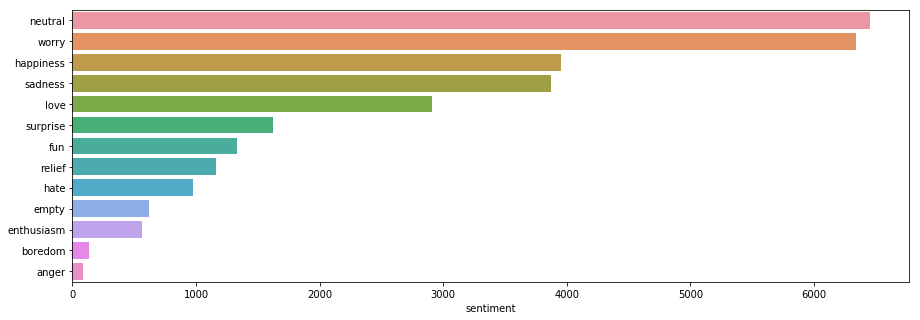

In [6]:
sentiment_count = df['sentiment'].value_counts(ascending = False)
plt.figure(figsize=(15, 5))
sns.barplot(sentiment_count, sentiment_count.index)

In [8]:
def top5(df, sentiment):
    cv = CountVectorizer(stop_words = 'english', max_features= 5)
    cv_fit = cv.fit_transform(df[df['sentiment'] == sentiment]['content'])
    words = cv.get_feature_names()
    words_freq = cv_fit.toarray().sum(axis=0)
    return pd.DataFrame(words_freq, index = words, columns = ['Cantidad']).sort_values(by=['Cantidad'], ascending=False)

In [9]:
for sentiment in sentiment_count.index:
    print("Sentiment: {}".format(sentiment))
    print(top10(df, sentiment).head(5))
    print("---------------------------------")

Sentiment: neutral
      Cantidad
just       436
http       413
day        321
com        311
quot       296
---------------------------------
Sentiment: worry
      Cantidad
just       521
like       344
day        317
don        313
got        304
---------------------------------
Sentiment: happiness
        Cantidad
day          492
good         428
just         324
happy        321
thanks       228
---------------------------------
Sentiment: sadness
      Cantidad
just       299
sad        295
day        271
miss       261
work       243
---------------------------------
Sentiment: love
        Cantidad
love         665
day          592
happy        452
good         243
mother       223
---------------------------------
Sentiment: surprise
      Cantidad
just       161
quot       114
day         95
oh          88
http        83
---------------------------------
Sentiment: fun
      Cantidad
lol        138
just       111
fun         99
quot        99
day         88
---------------

#### Se realiza el preprocesamiento de los datos
    * Se transforman los tweets a lower case
    * Se eliminan URLs y user mentions
    * Se excluyen stopwords mediante libreria nltk
    * Se muestran las 10 palabras con mayor frecuencia

In [98]:
def preprocesamiento(text):
    """
    Preprocesa un texto realizando las siguientes acciones:
        * Se transforma el texto a lower case
        * Se eliminan URL
        * Se eliminan user mentions
    Retorna el texto preprocesado.
    """
    text = text.lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text_temp = []
    for word in text.split(' '):
        text_temp.append(lemmatizer.lemmatize(word))
        
    text = ' '.join(text_temp)
    
    return text

In [101]:
sw = stopwords.words('english')
sw.append('doe')
sw.append('ha')
sw.append('wa')
cv = CountVectorizer(stop_words = sw, max_features= 10, preprocessor=preprocesamiento)
cv_fit = cv.fit_transform(df['content'])
words = cv.get_feature_names()
words_freq = cv_fit.toarray().sum(axis=0)
pd.DataFrame(words_freq, index = words, columns = ['Cantidad']).sort_values(by=['Cantidad'], ascending=False).head(10)

,Cantidad
day,2676
good,1736
get,1599
like,1474
go,1434
quot,1391
love,1317
work,1292
today,1279
got,1235


#### Se realiza el refinamiento de los datos

#### Preparación del vector objetivo y las matrices de entrenamiento y validación
* Se eliminan registros con sentiment igual a neutral
* Se recodifica el vector objetivo para trabajar con emociones positivas o negativas
    * Al recodificar el vector objetivo se observa que las clases se encuentran balanceadas
    * Las palabras con mayor frecuencia son similares en ambos grupos pero en los sentimientos Positivos destacan palabras como 'love' y 'happy', y en los sentimientos Negativos destacan 'work' y 'today'

In [102]:
index = df[df['sentiment'] == 'neutral'].index
df.drop(index, inplace=True)
df['sentiment'] = np.where(df['sentiment'].isin(
    ['happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']), 'Positiva', df['sentiment'])
df['sentiment'] = np.where(df['sentiment'].isin(
    ['worry', 'sadness', 'hate', 'empty', 'boredom', 'anger']), 'Negativa', df['sentiment'])

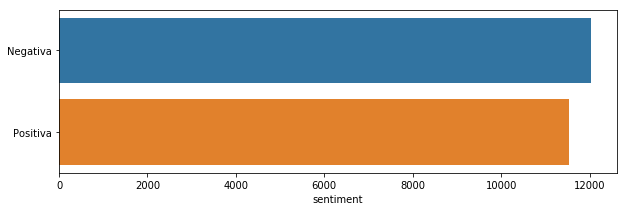

In [103]:
sentiment_count = df['sentiment'].value_counts(ascending = False)
plt.figure(figsize=(10, 3))
sns.barplot(sentiment_count, sentiment_count.index)

In [104]:
for sentiment in sentiment_count.index:
    print("Sentiment: {}".format(sentiment))
    print(top5(df, sentiment).head(5))
    print("---------------------------------")

Sentiment: Negativa
       Cantidad
just        969
day         665
like        647
work        646
today       560
---------------------------------
Sentiment: Positiva
       Cantidad
day        1417
good        975
just        964
love        933
happy       891
---------------------------------


#### Se binariza la variable objetivo y se generan las muestras de datos para entrenamiento y validación

In [105]:
label_encoder = LabelEncoder()
df['sentiment_bin'] = label_encoder.fit_transform(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment_bin'], random_state=11238, test_size = 0.33)

#### Entrenamiento de modelos
* Se realiza el entrenamiento utilizando los modelos: Bernoulli NB, Análisis Lineal Discriminante (LDA), Máquinas de Soporte Vectorial (SVC), Arboles de Decisión (DecisionTreeClassifier) y Gradient Boosting.
* Para cada modelo que presente la elección de hiperparámetros se realizará una búsqueda de grilla mediante GridSearchCV para determinar los valores más adecuados dentro de un rango definido.
* Se genera un Pipeline para cada modelo seleccionado y así también para las búsqueda de grilla.

In [106]:
def roc_curve_plot(y_test, y_pred_pr):
    false_positive, true_positive, threshold = roc_curve(y_test, y_pred_pr[:, 1])
    plt.figure(figsize=(5, 5))
    plt.title('Curva ROC')
    plt.plot(false_positive, true_positive, lw=1)
    plt.plot([0, 1], ls="--", lw=1, c='tomato')
    plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
    plt.ylabel('Verdaderos Positivos')
    plt.xlabel('Falsos Positivos')
    auc_score = roc_auc_score(y_test, y_pred_pr[:, 1])
    print("El área bajo la curva es de {}".format(auc_score))

##### Modelo 1: Bernoulli NB
* Para implemementar este modelo se consideran las primeras 500 palabras del CountVectorizer debido a que con mayor cantidad no se observa un desempeño notablemente mayor a cambio de mayor procesamiento. Por motivos de costo computacional se consideran 5 validaciones cruzadas en GridSearchCV.

In [108]:
grid_search_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = sw, max_features = 500, preprocessor = preprocesamiento)),
    ('grid', GridSearchCV(BernoulliNB(), param_grid = dict(alpha = np.linspace(0, 2, 20)[1:]), cv = 5, n_jobs=-1))
])
grid_search_cv.fit(X_train, y_train)
grid_step = grid_search_cv.named_steps['grid']
print("La mejor combinación de hiperparámetros son %s con un desempeño del %0.2f" % (grid_step.best_params_, grid_step.best_score_))

La mejor combinación de hiperparámetros son {'alpha': 0.10526315789473684} con un desempeño del 0.71


Classification Report Datos de Entrenamiento

              precision    recall  f1-score   support

           0       0.71      0.79      0.74      8013
           1       0.75      0.66      0.70      7764

   micro avg       0.73      0.73      0.73     15777
   macro avg       0.73      0.72      0.72     15777
weighted avg       0.73      0.73      0.72     15777

Classification Report Datos de Validación

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      4009
           1       0.72      0.64      0.68      3763

   micro avg       0.70      0.70      0.70      7772
   macro avg       0.71      0.70      0.70      7772
weighted avg       0.71      0.70      0.70      7772

El área bajo la curva es de 0.7787893794900883


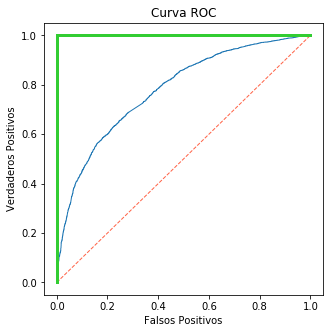

In [109]:
pipeline_model1 = Pipeline([
    ('cv', CountVectorizer(stop_words = sw, max_features = 500, preprocessor = preprocesamiento)), 
    ('bernoulli', BernoulliNB(alpha = 0.42))
])
pipeline_model1.fit(X_train, y_train)
print("Classification Report Datos de Entrenamiento\n")
train_pred = pipeline_model1.predict(X_train)
print(classification_report(y_train, train_pred))
print("Classification Report Datos de Validación\n")
test_pred = pipeline_model1.predict(X_test)
print(classification_report(y_test, test_pred))
test_pred_proba = pipeline_model1.predict_proba(X_test)
roc_curve_plot(y_test, test_pred_proba)

##### Modelo 2: Análisis Lineal Discriminante (LDA)
* Para implemementar este modelo se consideran las primeras 500 palabras del CountVectorizer debido a que con mayor cantidad no se observa un desempeño notablemente mayor a cambio de mayor procesamiento. Se debe realizar FunctionTransformer para integrar los datos generados con LDA.

In [22]:
from sklearn.preprocessing import FunctionTransformer

/Users/julio/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Classification Report Datos de Entrenamiento

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8013
           1       0.75      0.68      0.72      7764

   micro avg       0.73      0.73      0.73     15777
   macro avg       0.73      0.73      0.73     15777
weighted avg       0.73      0.73      0.73     15777

Classification Report Datos de Validación

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4009
           1       0.72      0.65      0.69      3763

   micro avg       0.71      0.71      0.71      7772
   macro avg       0.71      0.71      0.71      7772
weighted avg       0.71      0.71      0.71      7772

El área bajo la curva es de 0.7805957059014241


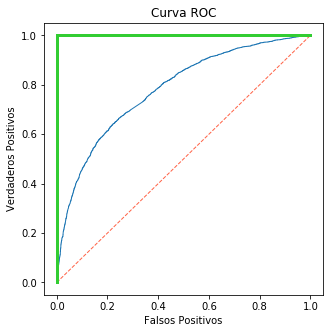

In [70]:
pipeline_model2 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)), 
    ('transform', FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate = True)),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline_model2.fit(X_train, y_train)
print("Classification Report Datos de Entrenamiento\n")
train_pred = pipeline_model2.predict(X_train)
print(classification_report(y_train, train_pred))
print("Classification Report Datos de Validación\n")
test_pred = pipeline_model2.predict(X_test)
print(classification_report(y_test, test_pred))
test_pred_proba = pipeline_model2.predict_proba(X_test)
roc_curve_plot(y_test, test_pred_proba)

##### Modelo 3: Máquinas de Soporte Vectorial (SVC)
* Para implemementar este modelo se consideran las primeras 500 palabras del CountVectorizer debido a que con mayor cantidad no se observa un desempeño notablemente mayor a cambio de mayor procesamiento. Por motivos de costo computacional se consideran 3 validaciones cruzadas en GridSearchCV. Los hiperparámetros que se hacen variar son C y gamma.

In [27]:
c_param_range = [0.01, 1, 100]
gamma_param_range = [0.001, 0.1, 10]
param_grid = dict(gamma = gamma_param_range, C = c_param_range)
grid_search_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)),
    ('grid', GridSearchCV(SVC(), param_grid = param_grid, cv = 3, n_jobs=-1))
])
grid_search_cv.fit(X_train, y_train)
grid_step = grid_search_cv.named_steps['grid']
print("La mejor combinación de hiperparámetros son %s con un desempeño del %0.2f" % (grid_step.best_params_, grid_step.best_score_))

La mejor combinación de hiperparámetros son {'C': 1, 'gamma': 0.1} con un desempeño del 0.70


/Users/julio/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Classification Report Datos de Entrenamiento

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      8013
           1       0.83      0.71      0.77      7764

   micro avg       0.79      0.79      0.79     15777
   macro avg       0.79      0.79      0.79     15777
weighted avg       0.79      0.79      0.79     15777

Classification Report Datos de Validación

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      4009
           1       0.74      0.62      0.67      3763

   micro avg       0.71      0.71      0.71      7772
   macro avg       0.71      0.70      0.70      7772
weighted avg       0.71      0.71      0.70      7772

El área bajo la curva es de 0.7840291512579292


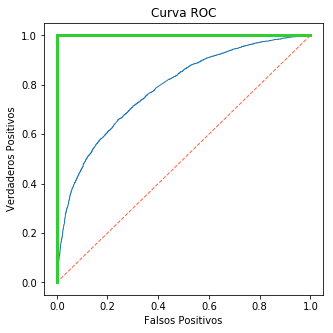

In [72]:
pipeline_model3 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)), 
    ('svc', SVC(kernel='rbf', C = 1, gamma = 0.1, probability = True))
])
pipeline_model3.fit(X_train, y_train)
print("Classification Report Datos de Entrenamiento\n")
train_pred = pipeline_model3.predict(X_train)
print(classification_report(y_train, train_pred))
print("Classification Report Datos de Validación\n")
test_pred = pipeline_model3.predict(X_test)
print(classification_report(y_test, test_pred))
test_pred_proba = pipeline_model3.predict_proba(X_test)
roc_curve_plot(y_test, test_pred_proba)

#### Modelo 4: Arboles de Decisión (DecisionTreeClassifier)
* Para implemementar este modelo se consideran las primeras 500 palabras del CountVectorizer debido a que con mayor cantidad no se observa un desempeño notablemente mayor a cambio de mayor procesamiento. Por motivos de costo computacional se consideran 3 validaciones cruzadas en GridSearchCV. Los hiperparámetros que se hacen variar son min_samples_split, criterion y max_depth.

In [29]:
min_samples_split_param_range = np.linspace(0.1, 1.0, 10)
criterion_param_range = ['gini', 'entropy']
max_depth_param_range = np.linspace(1, 50, 50)
param_grid = dict(
    min_samples_split = min_samples_split_param_range,
    criterion = criterion_param_range,
    max_depth = max_depth_param_range
)

grid_search_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)),
    ('grid', GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1))
])
grid_search_cv.fit(X_train, y_train)
grid_step = grid_search_cv.named_steps['grid']
print("La mejor combinación de hiperparámetros son %s con un desempeño del %0.2f" % (grid_step.best_params_, grid_step.best_score_))

La mejor combinación de hiperparámetros son {'criterion': 'gini', 'max_depth': 47.0, 'min_samples_split': 0.1} con un desempeño del 0.68


Classification Report Datos de Entrenamiento

              precision    recall  f1-score   support

           0       0.65      0.83      0.73      8013
           1       0.75      0.54      0.63      7764

   micro avg       0.68      0.68      0.68     15777
   macro avg       0.70      0.68      0.68     15777
weighted avg       0.70      0.68      0.68     15777

Classification Report Datos de Validación

              precision    recall  f1-score   support

           0       0.65      0.83      0.73      4009
           1       0.74      0.52      0.61      3763

   micro avg       0.68      0.68      0.68      7772
   macro avg       0.70      0.68      0.67      7772
weighted avg       0.70      0.68      0.67      7772

El área bajo la curva es de 0.6771073879943392


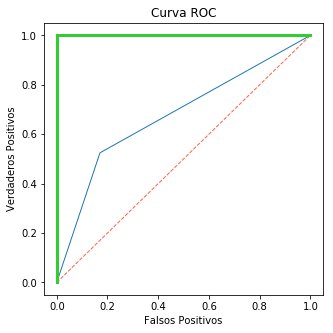

In [44]:
pipeline_model4 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)), 
    ('tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 47, min_samples_split = 0.1))
])
pipeline_model4.fit(X_train, y_train)
print("Classification Report Datos de Entrenamiento\n")
train_pred = pipeline_model4.predict(X_train)
print(classification_report(y_train, train_pred))
print("Classification Report Datos de Validación\n")
test_pred = pipeline_model4.predict(X_test)
print(classification_report(y_test, test_pred))
test_pred_proba = pipeline_model4.predict_proba(X_test)
roc_curve_plot(y_test, test_pred_proba)

#### Modelo 5: Gradient Boosting
* Para implemementar este modelo se consideran las primeras 500 palabras del CountVectorizer debido a que con mayor cantidad no se observa un desempeño notablemente mayor a cambio de mayor procesamiento. Por motivos de costo computacional se consideran 3 validaciones cruzadas en GridSearchCV. Los hiperparámetros que se hacen variar son learning_rate y n_estimators.

In [31]:
n_estimators_param_range = [100, 500, 1000]
learning_rate_param_range = [0.01, 0.1, 1, 10]
param_grid = dict(
    learning_rate = learning_rate_param_range,
    n_estimators = n_estimators_param_range
)

grid_search_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)),
    ('grid', GridSearchCV(GradientBoostingClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1))
])
grid_search_cv.fit(X_train, y_train)
grid_step = grid_search_cv.named_steps['grid']
print("La mejor combinación de hiperparámetros son %s con un desempeño del %0.2f" % (grid_step.best_params_, grid_step.best_score_))

La mejor combinación de hiperparámetros son {'learning_rate': 0.1, 'n_estimators': 1000} con un desempeño del 0.70


Classification Report Datos de Entrenamiento

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      8013
           1       0.81      0.70      0.75      7764

   micro avg       0.77      0.77      0.77     15777
   macro avg       0.77      0.77      0.77     15777
weighted avg       0.77      0.77      0.77     15777

Classification Report Datos de Validación

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      4009
           1       0.73      0.61      0.67      3763

   micro avg       0.70      0.70      0.70      7772
   macro avg       0.71      0.70      0.70      7772
weighted avg       0.70      0.70      0.70      7772

El área bajo la curva es de 0.6989534310490739


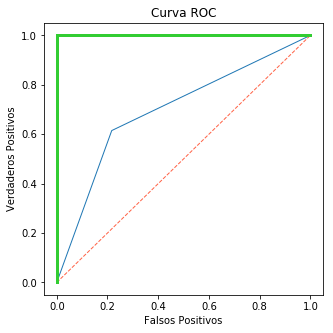

In [45]:
pipeline_model5 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features = 500, preprocessor = preprocesamiento)), 
    ('tree', GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 1000))
])
pipeline_model5.fit(X_train, y_train)
print("Classification Report Datos de Entrenamiento\n")
train_pred = pipeline_model5.predict(X_train)
print(classification_report(y_train, train_pred))
print("Classification Report Datos de Validación\n")
test_pred = pipeline_model5.predict(X_test)
print(classification_report(y_test, test_pred))
test_pred_proba = pipeline_model5.predict_proba(X_test)
roc_curve_plot(y_test, test_pred_proba)

In [88]:
l = stopwords.words('english')
l.append('doe')
l.append('ha')
l.append('wa')
print(l)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '